<a href="https://colab.research.google.com/github/cverluise/PatCit/blob/nightly/notebook/frontpage_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from google.cloud import bigquery
from google.oauth2 import service_account

# Set up

> If you don't have the JSON file that contains your key yet, follow the instructions to [create a service account](https://cloud.google.com/docs/authentication/getting-started#creating_a_service_account)

In [ ]:
# Upload your credentials
uploaded = files.upload() 

Saving npl-parsing-3412b4cafd20.json to npl-parsing-3412b4cafd20.json


In [ ]:
key_path = "./npl-parsing-3412b4cafd20.json" # change the name to match your credentials file name

In [ ]:
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(
    credentials=credentials,
    project=credentials.project_id,
)

In [ ]:
meta_table = "npl-parsing.external.v03_front_page_meta_future"
FIG_SIZE = (9,6)

# Nb docs

## All time

In [ ]:
query = f"""
SELECT
  npl_cat,
  COUNT(DISTINCT(patcit_id)) AS nb_patcit_id,
  COUNT(DISTINCT(npl_publn_id)) AS nb_npl_publn_id
FROM
  `{meta_table}`,
  UNNEST(npl_publn_id) AS npl_publn_id
GROUP BY
  npl_cat
ORDER BY
  nb_patcit_id DESC
"""

In [ ]:
tmp = client.query(query).to_dataframe()

In [ ]:
for v in ["patcit_id", "npl_publn_id"]:
  tmp[f"share_{v}"] = tmp[f"nb_{v}"]/tmp[f"nb_{v}"].sum()


In [ ]:
tmp

,npl_cat,nb_patcit_id,nb_npl_publn_id,share_patcit_id,share_npl_publn_id
0,BIBLIOGRAPHICAL_REFERENCE,13840368,27230724,0.665782,0.695929
1,OFFICE_ACTION,1722958,3227141,0.082882,0.082475
2,PATENT,1379424,2510056,0.066356,0.064149
3,SEARCH_REPORT,1342408,2270016,0.064576,0.058014
4,PRODUCT_DOCUMENTATION,926675,1544027,0.044577,0.039460
5,NORM_STANDARD,617419,819241,0.029701,0.020937
6,WEBPAGE,464550,733876,0.022347,0.018755
7,DATABASE,288962,359360,0.013900,0.009184
8,LITIGATION,133822,262909,0.006437,0.006719
9,WIKI,71398,105704,0.003435,0.002701


## ~~By year~~

<font color="orange">TODO</font>

> So far we cannot assign a date to each NPL docs. Precisely, we can do it only for BIBREF (+ NORM_STANDARD, WIKI, DATABASE in dev).

# Citations received

## All time

In [ ]:
query = f"""
SELECT
  npl_cat,
  COUNT(DISTINCT(patcit_id)) AS nb_patcit_id,
  SUM(is_cited_by_count) AS nb_citations_received
FROM
  `{meta_table}`
GROUP BY
  npl_cat
ORDER BY
  nb_patcit_id DESC
"""

In [ ]:
tmp = client.query(query).to_dataframe()

In [ ]:
tmp["avg_citations_received_by_doc"] = tmp["nb_citations_received"]/tmp["nb_patcit_id"]
tmp.sort_values("avg_citations_received_by_doc", ascending=False).iloc[1:]

,npl_cat,nb_patcit_id,nb_citations_received,avg_citations_received_by_doc
0,BIBLIOGRAPHICAL_REFERENCE,13840368,30906437,2.233065
8,LITIGATION,133822,262928,1.964759
2,PATENT,1379424,2667273,1.933614
1,OFFICE_ACTION,1722958,3228725,1.873943
6,WEBPAGE,464550,789766,1.700067
4,PRODUCT_DOCUMENTATION,926675,1570325,1.694580
3,SEARCH_REPORT,1342408,2270140,1.691095
5,NORM_STANDARD,617419,960473,1.555626
7,DATABASE,288962,447313,1.547999
9,WIKI,71398,110006,1.540743


Look at:
- the **distribution** of `nb_citations_received` by `npl_cat` over time/space
- average nb of `npl_citation` _per_ patent over time/space

## By year

In [ ]:
query = f"""
SELECT
  npl_cat,
  CAST(cited_by.publication_date/10000 AS INT64) AS citation_year,
  COUNT(DISTINCT(patcit_id)) AS nb_patcit_id,
  COUNT(cited_by.publication_number) AS nb_citations_received
FROM
  `{meta_table}`,
  UNNEST(cited_by) AS cited_by
GROUP BY
  npl_cat,
  citation_year
ORDER BY
  npl_cat,
  citation_year DESC"""

In [ ]:
tmp = client.query(query).to_dataframe()

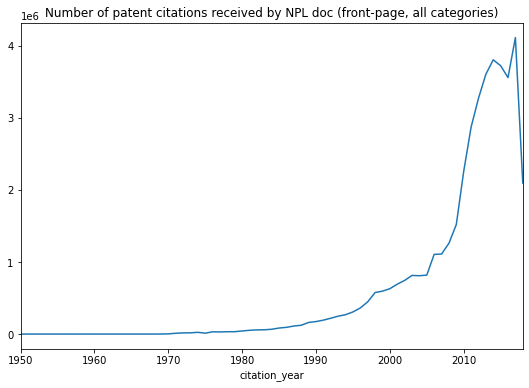

In [ ]:
(tmp
 .groupby("citation_year")
 .sum()["nb_citations_received"]
 .plot(xlim=(1950,2018), 
       figsize=FIG_SIZE, 
       title= "Number of patent citations received by NPL doc (front-page, all categories)")
);

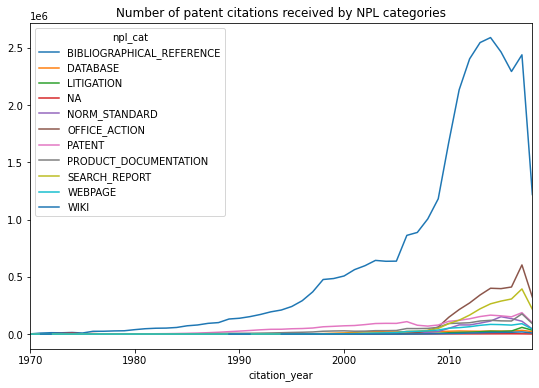

In [ ]:
(tmp
 .pivot(index="citation_year", columns="npl_cat", values="nb_citations_received")
 .plot(xlim=(1970,2018), 
       figsize=FIGSIZE,
       title="Number of patent citations received by NPL categories")
);

In [ ]:
tmp_ = tmp.pivot(index="citation_year", columns="npl_cat", values="nb_citations_received")
tmp_["total"] = tmp_.sum(1)
vars = list(tmp_.columns)
vars.remove("total")
for var in vars:
  tmp_[var] = tmp_[var]/tmp_["total"]

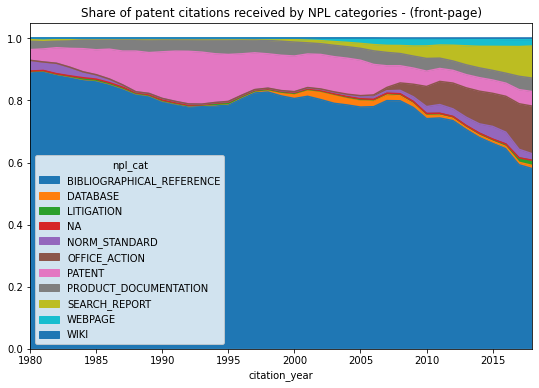

In [ ]:
(tmp_[vars]
 .plot(xlim=(1980,2018), kind="area", figsize=FIG_SIZE, title="Share of patent citations received by NPL categories (front-page)"));

In [ ]:
year = 2015
print(f"Share of NPL citations received by NPL cat in {year}")
(tmp_
 .loc[year]
 .sort_values(ascending=False)
 .iloc[1:]
 .to_frame())


Share of NPL citations received by NPL cat in 2015


,2015
npl_cat,
BIBLIOGRAPHICAL_REFERENCE,0.661621
OFFICE_ACTION,0.106559
SEARCH_REPORT,0.077358
PATENT,0.042756
NORM_STANDARD,0.040718
PRODUCT_DOCUMENTATION,0.030978
WEBPAGE,0.022139
DATABASE,0.007002
LITIGATION,0.006286


# Citation origin

## By patent office

In [ ]:
query = f"""SELECT
  SPLIT(cited_by.publication_number,"-")[OFFSET(0)] AS country_code,
  CAST(cited_by.publication_date /10000 AS INT64) AS publication_year,
  COUNT(cited_by.publication_number) AS nb_citations_sent
FROM
  `{meta_table}`,
  UNNEST(cited_by) AS cited_by
GROUP BY
  country_code,
  publication_year"""

In [ ]:
tmp = client.query(query).to_dataframe()

In [ ]:
tmp_ = (tmp.
 pivot(index="publication_year", columns="country_code", values="nb_citations_sent")
 .sum()
 .sort_values(ascending=False)
 .to_frame().rename(columns={0:"nb_citations_sent"}))
tmp_["share_citations_sent"] = tmp_/tmp_.sum()*100

In [ ]:
n = 10
topn = list(tmp_[:n].index)
print(f"Share of citations sent by patent office - All time")
tmp_[:n]


Share of citations sent by patent office - All time


,nb_citations_sent,share_citations_sent
country_code,,
US,29137738.0,67.324785
EP,5925499.0,13.691281
WO,4240879.0,9.798848
CN,2011986.0,4.648835
DE,741549.0,1.713401
JP,501330.0,1.158358
FR,290283.0,0.670719
GB,103644.0,0.239477
AU,87826.0,0.202928


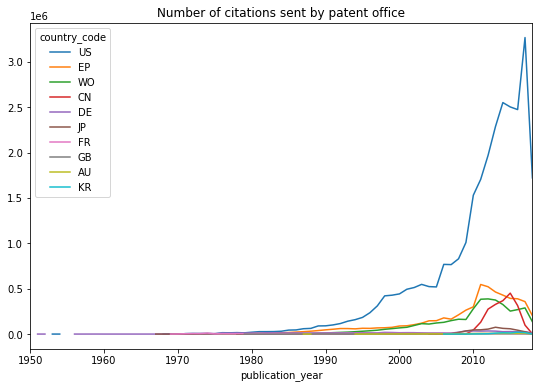

In [ ]:
(tmp
 .pivot(index="publication_year", columns="country_code", values="nb_citations_sent")[topn]
 .plot(xlim=(1950,2018), 
       figsize=FIG_SIZE, 
       title="Number of citations sent by patent office"));

In [ ]:
tmp_ = tmp.pivot(index="publication_year", columns="country_code", values="nb_citations_sent")
tmp_["total"] = tmp_.sum(1)#.plot(xlim=(1970,2018), kind="area")
cols = list(tmp_.columns)
cols.remove("total")
for col in cols:
  tmp_[col] = tmp_[col]/tmp_["total"]


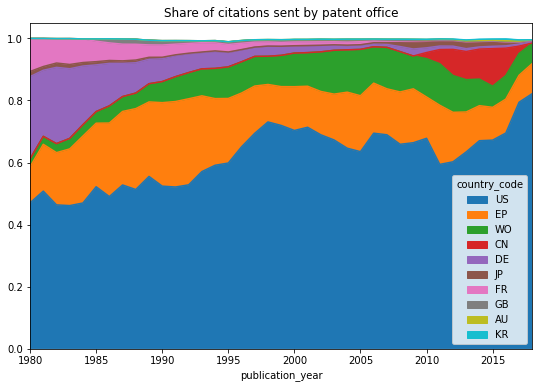

In [ ]:
tmp_[topn].plot(xlim=(1980,2018), 
                 kind="area", 
                 figsize=FIG_SIZE, 
                 title="Share of citations sent by patent office");

## By patent agent

In [ ]:
query = f"""
SELECT
  cited_by.origin,
  CAST(cited_by.publication_date /10000 AS INT64) AS publication_year,
  COUNT(cited_by.publication_number) AS nb_citations_sent
FROM
  `{meta_table}`,
  UNNEST(cited_by) AS cited_by
GROUP BY
  cited_by.origin,
  publication_year
"""  

In [ ]:
tmp = client.query(query).to_dataframe()

In [ ]:
tmp_ = tmp.groupby("origin").sum().sort_values("nb_citations_sent", ascending=False)
tmp_["share_citations_sent"] = tmp_["nb_citations_sent"]/sum(tmp_["nb_citations_sent"])
print("Number and share of patent citations sent by patent agent")
tmp_.filter(regex = "citations_sent")

Number and share of patent citations sent by patent agent


,nb_citations_sent,share_citations_sent
origin,,
APP,29319338,6.774438e-01
SEA,9392008,2.170089e-01
ISR,3141861,7.259490e-02
PRS,901108,2.082073e-02
EXA,442834,1.023199e-02
FOP,31212,7.211751e-04
TPO,25216,5.826333e-04
OPP,18600,4.297660e-04
APL,6915,1.597759e-04


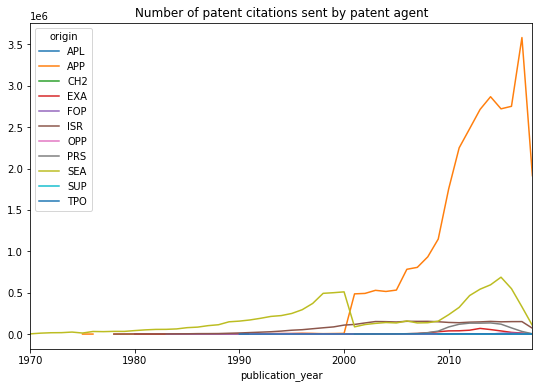

In [ ]:
(tmp
 .pivot(index="publication_year", columns="origin", values="nb_citations_sent")
 .plot(xlim=(1970,2018),
       figsize=FIG_SIZE,
       title="Number of patent citations sent by patent agent"));

In [ ]:
tmp_ = tmp.pivot(index="publication_year", columns="origin", values="nb_citations_sent")
tmp_["total"] = tmp_.sum(1)
cols = list(tmp_.columns)
cols.remove("total")
for col in cols:
  tmp_[col] = tmp_[col]/tmp_["total"]

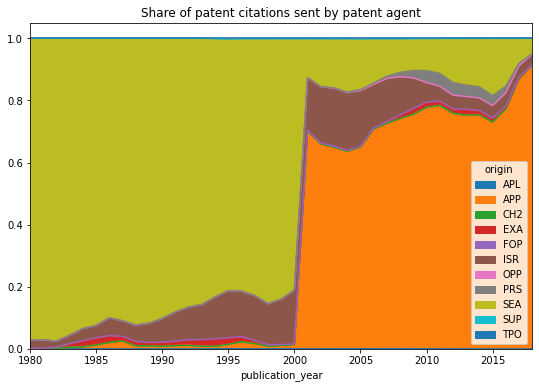

In [ ]:
tmp_[cols].plot(xlim=(1980,2018), 
                 kind="area", 
                 figsize=FIG_SIZE, 
                 title = "Share of patent citations sent by patent agent");

There seems to be a change in coding rules in the 2000


**NOTE**

- `APP` citations introduced by the applicant
- `SEA` citations introduced during search (from Search Report)
- `ISR` citations from the International Search Report
- `SUP` citations from the Supplementary Search Report
- `PRS` "PRe-Search" citations (available before official publication)
- `EXA` citations introduced during examination
- `OPP` citations introduced during opposition (citations by opponent published - with a European Patent Specification (EP-B2))
- `APL` citations introduced when filed for appeal by applicant / proprietor / patentee
- `FOP` citations introduced when filed opposition by any third party after the publication of a European Patent Specification (EP- B1)
- `TPO` citations introduced because of Third Party Observations (Art 115 EPC)
- `CH2` citations introduced during the Chapter 2 phase of the PCT

## By technological class

<font color="orange">TODO</font>

# Citation properties

## Language

In [ ]:
query = f"""
SELECT
  language_code,
  CAST(cited_by.publication_date /10000 AS INT64) AS publication_year,
  COUNT(cited_by.publication_number) AS nb_citations_received
FROM
  `{meta_table}`,
  UNNEST(cited_by) AS cited_by
GROUP BY
  language_code,
  publication_year
"""  

In [ ]:
tmp = client.query(query).to_dataframe()

In [ ]:
tmp_ = tmp.pivot(index="publication_year", columns="language_code", values="nb_citations_received")

In [ ]:
n = 10
topn = list(tmp_
 .sum()
 .sort_values(ascending=False)
 .iloc[:n].index)

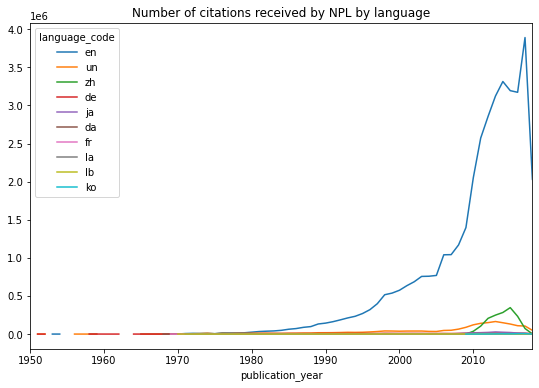

In [ ]:
tmp_[topn].plot(xlim=(1950,2018), figsize=FIG_SIZE, title="Number of citations received by NPL by language");


In [ ]:
tmp_["total"] = tmp_.sum(1)
cols = list(tmp_.columns)
cols.remove("total")
for col in cols:
  tmp_[col] = tmp_[col]/tmp_["total"]

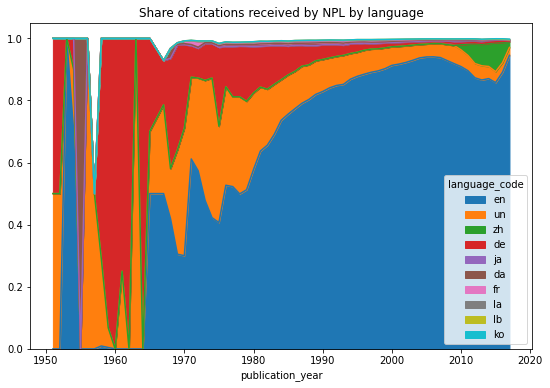

In [ ]:
(tmp_
 .query("1950<publication_year<2018")[topn]
 .plot(kind="area", figsize=FIG_SIZE, title="Share of citations received by NPL by language"));